## Part 1: Environment Setup & Introduction

For our third model in the Spark environment, we select **Logistic Regression**.

**Why Logistic Regression?**
1.  **Efficiency:** It is highly scalable and trains significantly faster than complex models like SVM or Random Forest on large datasets.
2.  **Interpretability:** It provides clear coefficients that indicate the relationship between features (e.g., `sbytes`) and the probability of an attack.
3.  **Probabilistic Output:** Unlike a standard SVM, it naturally outputs probabilities, making it ideal for ROC-AUC evaluation.

**Key Components:**
* `LogisticRegression`: The Spark MLlib implementation of log-linear models.
* `StandardScaler`: Used to normalize features, which is essential for the regularization (L1/L2) used in Logistic Regression.

In [1]:
# # Install PySpark
# !pip install pyspark -q

# # Mount Drive
# from google.colab import drive
# drive.mount('/content/drive')

# Core Libraries
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PySpark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, abs as spark_abs
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import RFormula, StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType

# Initialize Session
spark = SparkSession.builder \
    .appName("CSCI316_Task2_LogReg") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

print("Spark Session Created!")

26/02/22 14:15:11 WARN Utils: Your hostname, ijuwon-ui-MacBookPro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.8 instead (on interface en0)
26/02/22 14:15:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/22 14:15:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
26/02/22 14:15:11 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Spark Session Created!


## Part 2: Data Loading & Splitting

To ensure a valid comparison with our other models, we implement a consistent data handling strategy:

1.  **Merging Datasets:** We load the original training and testing CSVs and merge them into a single DataFrame. This allows us to perform a global shuffle and split.
2.  **Dropping Leakage:** We remove the `id` and `attack_cat` columns to prevent data leakage.
3.  **Feature Engineering (Manual):**
    * **`pkt_ratio`**: The ratio of source packets to destination packets ($(spkts+1)/(dpkts+1)$).
    * **`ttl_gap`**: The absolute difference between Source TTL and Destination TTL.
    * *Note:* These features mirror the ones created in our Random Forest model for consistency.
4.  **Stratified Split:**
    * We perform a **70% Train / 15% Validation / 15% Test** split based on the `label` column to maintain class balance.

In [2]:
def load_and_prep_spark_data():
    # Update paths
    train_path = '/content/drive/MyDrive/University/CSCI316 - Big Data Mining Techniques/Group Assignment/UNSW_NB15_training-set.csv'
    test_path = '/content/drive/MyDrive/University/CSCI316 - Big Data Mining Techniques/Group Assignment/UNSW_NB15_testing-set.csv'
     # Juwon's Local file path
    test_path = '/Users/jju/Documents/SIM/Semester 1, 2026/CSCI316 Big Data Mining/Assignments/Group_Assignment_Database/UNSW_NB15_testing-set.csv'
    train_path = '/Users/jju/Documents/SIM/Semester 1, 2026/CSCI316 Big Data Mining/Assignments/Group_Assignment_Database/UNSW_NB15_training-set.csv'

    print("Loading data...")
    df_train_orig = spark.read.csv(train_path, header=True, inferSchema=True)
    df_test_orig = spark.read.csv(test_path, header=True, inferSchema=True)

    # 1. Combine Datasets
    # Drop ID and attack_cat (Fixes Leakage)
    df_full = df_train_orig.unionByName(df_test_orig).drop('id', 'attack_cat')

    # 2. Feature Engineering (Matches others)
    df_full = df_full.withColumn("pkt_ratio", (col("spkts") + 1) / (col("dpkts") + 1))
    df_full = df_full.withColumn("ttl_gap", spark_abs(col("sttl") - col("dttl")))

    # 3. Stratified Split (70/15/15)
    zeros = df_full.filter(col("label") == 0)
    ones = df_full.filter(col("label") == 1)

    train_0, val_0, test_0 = zeros.randomSplit([0.7, 0.15, 0.15], seed=42)
    train_1, val_1, test_1 = ones.randomSplit([0.7, 0.15, 0.15], seed=42)

    train_data = train_0.union(train_1)
    val_data = val_0.union(val_1)
    test_data = test_0.union(test_1)

    print(f"Split Sizes -> Train: {train_data.count()}, Val: {val_data.count()}, Test: {test_data.count()}")
    return train_data, val_data, test_data

train_df, val_df, test_df = load_and_prep_spark_data()

Loading data...


26/02/22 14:15:15 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Split Sizes -> Train: 180973, Val: 38573, Test: 38127


## Part 3: Building the Logistic Regression Pipeline

We construct a Spark ML `Pipeline` consisting of three stages.

**Pipeline Stages:**
1.  **`RFormula` (Encoding):**
    * We define the model formula: `label ~ . + dur:sbytes`.
    * This stage automatically converts string columns (`proto`, `service`, `state`) into numerical vectors using **One-Hot Encoding**.
    * It also creates the required interaction term `dur:sbytes`.
2.  **`StandardScaler` (Scaling):**
    * Logistic Regression coefficients are sensitive to scale. We standardize features to mean=0 and std=1.
3.  **`LogisticRegression` (Model):**
    * The linear classifier.

In [3]:
def build_lr_pipeline(train_data):
    # 1. RFormula (One-Hot Encoding + Interaction Term)
    # "label ~ . + dur:sbytes"
    categorical_cols = ['proto', 'service', 'state']
    numeric_cols = [f.name for f in train_data.schema.fields
                    if f.dataType.simpleString() != 'string' and f.name != 'label']

    formula_string = "label ~ " + " + ".join(categorical_cols + numeric_cols) + " + dur:sbytes"

    rformula = RFormula(
        formula=formula_string,
        featuresCol="raw_features",
        labelCol="label_target",
        handleInvalid="keep"
    )

    # 2. Scaling (Important for Regularization in LR)
    scaler = StandardScaler(
        inputCol="raw_features",
        outputCol="features",
        withStd=True,
        withMean=False
    )

    # 3. Logistic Regression
    lr = LogisticRegression(
        featuresCol="features",
        labelCol="label_target",
        maxIter=100
    )

    pipeline = Pipeline(stages=[rformula, scaler, lr])
    return pipeline, lr

pipeline, lr_obj = build_lr_pipeline(train_df)

## Part 4: Training and Hyperparameter Tuning

We use `CrossValidator` to tune the model's hyperparameters.

**Grid Search Parameters:**
* **`regParam`:** Controls the regularization strength (lambda). We test `[0.01, 0.1, 1.0]`.
* **`elasticNetParam`:** Controls the mix between L1 (Lasso) and L2 (Ridge) regularization.
    * `0.0` = Ridge (L2)
    * `1.0` = Lasso (L1)

**Evaluation Metric:**
* We optimize for **F1 Score**.

In [4]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

rformula_stage = pipeline.getStages()[0]

# 1. Define the Formulas for comparison
categorical_cols = ['proto', 'service', 'state']
numeric_cols = [f.name for f in train_df.schema.fields
                if f.dataType.simpleString() != 'string' and f.name != 'label']

all_features = categorical_cols + numeric_cols
formula_with = "label ~ " + " + ".join(all_features) + " + dur:sbytes"
formula_without = "label ~ " + " + ".join(all_features)

# 2. Update ParamGrid: Toggle formula, regParam, and elasticNetParam
paramGrid = ParamGridBuilder() \
    .addGrid(rformula_stage.formula, [formula_with, formula_without]) \
    .addGrid(lr_obj.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr_obj.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# 3. Use MulticlassClassificationEvaluator for F1-Score
evaluator = MulticlassClassificationEvaluator(
    labelCol="label_target",
    predictionCol="prediction",
    metricName="f1"
)

# 4. Cross-Validation setup
crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3,
    parallelism=2
)

print("Starting Logistic Regression Training (Optimizing for F1-Score)...")
start_time = time.time()
cvModel = crossval.fit(train_df)
duration = time.time() - start_time

# 5. Extract and Print Validation Metrics
avg_metrics = cvModel.avgMetrics
params = crossval.getEstimatorParamMaps()
results = sorted(zip(params, avg_metrics), key=lambda x: x[1], reverse=True)

print(f"\nGrid Search Complete in {duration:.2f} seconds.")

print("\n--- All Hyperparameter Combinations (Validation F1) ---")
for i, (p, score) in enumerate(results):
    has_extra = "True" if "dur:sbytes" in p[rformula_stage.formula] else "False"
    reg = p[lr_obj.regParam]
    enet = p[lr_obj.elasticNetParam]
    print(f"Rank {i+1}: F1: {score:.4f} | Extra: {has_extra} | Reg: {reg} | ElasticNet: {enet}")

# Best Model Stats
best_model = cvModel.bestModel
best_lr_stage = best_model.stages[-1]
best_formula = best_model.stages[0].getFormula()

print(f"\nBest Parameters:")
print(f"- Use Extra Feature: {'True' if 'dur:sbytes' in best_formula else 'False'}")
print(f"- RegParam: {best_lr_stage.getRegParam()}")
print(f"- ElasticNetParam: {best_lr_stage.getElasticNetParam()}")
print(f"- Best Validation F1-Score: {max(avg_metrics):.4f}")

Starting Logistic Regression Training (Optimizing for F1-Score)...


26/02/22 14:15:23 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS



Grid Search Complete in 170.12 seconds.

--- All Hyperparameter Combinations (Validation F1) ---
Rank 1: F1: 0.8925 | Extra: True | Reg: 0.01 | ElasticNet: 0.0
Rank 2: F1: 0.8924 | Extra: False | Reg: 0.01 | ElasticNet: 0.0
Rank 3: F1: 0.8884 | Extra: False | Reg: 0.01 | ElasticNet: 0.5
Rank 4: F1: 0.8883 | Extra: True | Reg: 0.01 | ElasticNet: 0.5
Rank 5: F1: 0.8870 | Extra: True | Reg: 0.01 | ElasticNet: 1.0
Rank 6: F1: 0.8870 | Extra: False | Reg: 0.01 | ElasticNet: 1.0
Rank 7: F1: 0.8854 | Extra: False | Reg: 0.1 | ElasticNet: 0.0
Rank 8: F1: 0.8854 | Extra: True | Reg: 0.1 | ElasticNet: 0.0
Rank 9: F1: 0.8758 | Extra: True | Reg: 0.1 | ElasticNet: 0.5
Rank 10: F1: 0.8758 | Extra: False | Reg: 0.1 | ElasticNet: 0.5
Rank 11: F1: 0.8632 | Extra: True | Reg: 0.1 | ElasticNet: 1.0
Rank 12: F1: 0.8632 | Extra: False | Reg: 0.1 | ElasticNet: 1.0
Rank 13: F1: 0.8603 | Extra: False | Reg: 1.0 | ElasticNet: 0.0
Rank 14: F1: 0.8603 | Extra: True | Reg: 1.0 | ElasticNet: 0.0
Rank 15: F1: 0.4

## Part 5: Final Evaluation on Test Set

We evaluate the best model found by Cross-Validation on the unseen **Test Data (15%)**.

**Metrics Calculation:**
* We cast predictions to `FloatType` to utilize Spark's `MulticlassMetrics`.
* We report **Accuracy**, **Weighted Precision**, **Weighted Recall**, and **Weighted F1-Score**.
* A **Confusion Matrix** is plotted to visualize the misclassifications.


       FINAL EVALUATION: UNSEEN TEST DATA (Logistic Regression)


/Users/jju/Documents/SIM/Semester 1, 2026/CSCI316 Big Data Mining/Assignments/.venv/lib/python3.9/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



  SPARK LR SUMMARY
   Metric Spark LogReg
 Accuracy       0.8991
Precision       0.9073
   Recall       0.8991
 F1-Score       0.8955


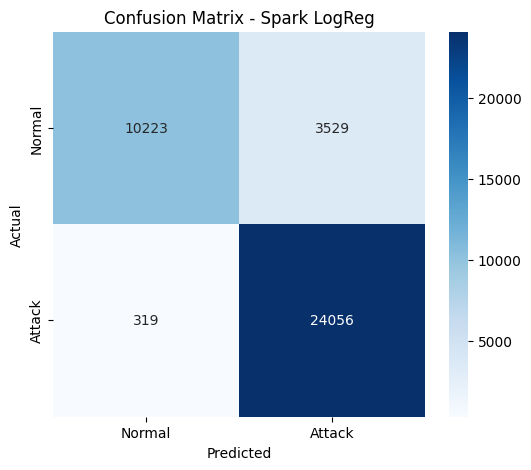

In [5]:
def evaluate_spark_model(model, test_data):
    print("\n" + "="*60)
    print("       FINAL EVALUATION: UNSEEN TEST DATA (Logistic Regression)")
    print("="*60)

    # Clean old columns
    for c in ["label_target", "raw_features", "features", "prediction", "rawPrediction", "probability"]:
        if c in test_data.columns:
            test_data = test_data.drop(c)

    predictions = model.transform(test_data)

    predictionAndLabels = predictions.select(
        col("prediction").cast(FloatType()),
        col("label_target").cast(FloatType())
    ).rdd

    metrics = MulticlassMetrics(predictionAndLabels)

    # Summary
    summary = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
        'Spark LogReg': [
            f"{metrics.accuracy:.4f}",
            f"{metrics.weightedPrecision:.4f}",
            f"{metrics.weightedRecall:.4f}",
            f"{metrics.weightedFMeasure():.4f}"
        ]
    })
    print("\n" + "="*60)
    print("  SPARK LR SUMMARY")
    print("="*60)
    print(summary.to_string(index=False))

    # Confusion Matrix
    cm = metrics.confusionMatrix().toArray()
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues',
                xticklabels=['Normal', 'Attack'],
                yticklabels=['Normal', 'Attack'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - Spark LogReg')
    plt.show()

evaluate_spark_model(cvModel.bestModel, test_df)